# Load dependencies and tables

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown as md

In [31]:
output_tables = "output_tables"
run_dir_name = "2024_11_11_14_53_output"
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

# Filter results within samples

In [34]:
# Merged table for analyzing filter results
display(md("## Merged table for analyzing filter results"))
df_filter = df_truncate_mapping
df_filter = df_filter.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df_filter = df_filter.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
display(df_filter.describe())

## Merged table for analyzing filter results

,srr_name,zotu_id,trunc_zotu_id,passed_trunc,passed_abun_full,passed_contam_full,passed_abun_trunc,passed_contam_trunc
count,65596,65596,64280,65596,65596,65596,64280,64280
unique,190,868,855,2,2,2,2,2
top,NBCLAB4208,Zotu1,Zotu18,True,False,False,False,False
freq,868,190,202,64280,59472,60479,57653,58876


In [35]:
#Filter results on full length ZOTUs
df_filter_counts = pd.DataFrame.join(
    df_filter.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df_filter.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_filter_counts.loc[(True,""),:] = df_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_filter_counts)

num_passed_abun_full = df_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun_full} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter"))

## Filter results on full length ZOTUs

Of all 65596 full length ZOTUs found across all samples:

count  proportion
passed_abun_full passed_contam_full                     
False            False               59472.0    0.906641
True             True                 5117.0    0.078008
                 False                1007.0    0.015352
                                      6124.0    0.093359

- 6124.0 (9.34%) passed the abundance filter
- 5117.0 (7.80% of all, 83.56% of abundant) passed the contamination filter

In [40]:
# Truncation results on full length ZOTUs
df_trunc = df_filter[df_filter["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df_filter.value_counts(subset="passed_trunc"),
    df_filter.value_counts(subset="passed_trunc", normalize=True))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
display(md("## Truncation results on full length ZOTUs"))
display(md(f"Of all {df_filter.shape[0]} full length ZOTUs found across all samples:"))
display(df_trunc_counts)

num_passed_trunc = df_trunc_counts.loc[True]['count']
prop_passed_trunc = df_trunc_counts.loc[True]['proportion']
num_not_passed_trunc = df_trunc_counts.loc[False]['count']
prop_not_passed_trunc = df_trunc_counts.loc[False]['proportion']
display(md(f"- {num_passed_trunc} ({prop_passed_trunc:.2%}) passed truncation\n"
           f"\t- {df_trunc_counts.loc[True]['count derep']} after dereplication within samples\n"
           f"- {num_not_passed_trunc} ({prop_not_passed_trunc:.2%}) did not pass truncation (<250bp) and are discarded"))

## Truncation results on full length ZOTUs

Of all 65596 full length ZOTUs found across all samples:

,count,proportion,count derep
passed_trunc,,,
True,64280,0.979938,61373.0
False,1316,0.020062,NaN


- 64280.0 (97.99%) passed truncation
	- 61373.0 after dereplication within samples
- 1316.0 (2.01%) did not pass truncation (<250bp) and are discarded

In [41]:
# Filter results on discarded ZOTUs
df_not_trunc = df_filter[df_filter["passed_trunc"] == False]
df_not_trunc_filter_counts = pd.DataFrame.join(
    df_not_trunc.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df_not_trunc.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_not_trunc_filter_counts.loc[(True,""),:] = df_not_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on discarded ZOTUs"))
display(md(f"Of the {df_not_trunc.shape[0]} full length ZOTUs that do not pass truncation (<250bp):"))
display(df_not_trunc_filter_counts)

num_passed_abun_disc = df_not_trunc_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_not_trunc_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_not_trunc_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_not_trunc_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun_disc} ({prop_passed_abun:.2%}) would have passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) would have passed the contamination filter"))

## Filter results on discarded ZOTUs

Of the 1316 full length ZOTUs that do not pass truncation (<250bp):

count  proportion
passed_abun_full passed_contam_full                    
False            False               1254.0    0.952888
True             True                  44.0    0.033435
                 False                 18.0    0.013678
                                       62.0    0.047112

- 62.0 (4.71%) would have passed the abundance filter
- 44.0 (3.34% of all, 70.97% of abundant) would have passed the contamination filter

In [8]:
# Filter results on truncated ZOTUs
df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True), rsuffix=" derep")
df_trunc_filter_counts.loc[(True,""),:] = df_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion', 'count derep', 'proportion derep']].sum()
display(md("## Filter results on truncated ZOTUs"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_trunc_filter_counts)

num_passed_abun = df_trunc_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_trunc_filter_counts.loc[(True, '')]['proportion']
num_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['count derep']
prop_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['proportion derep']
num_passed_contam = df_trunc_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_trunc_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
num_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['count derep']
prop_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['proportion derep']
prop_passed_contam_abun_derep = prop_passed_contam_derep / prop_passed_abun_derep
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"\t- {num_passed_abun_derep} ({prop_passed_abun_derep:.2%}) after dereplication within samples\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter\n"
           f"\t- {num_passed_contam_derep} ({prop_passed_contam_derep:.2%} of all, {prop_passed_contam_abun_derep:.2%} of abundant) after dereplication within samples"))

## Filter results on truncated ZOTUs

Of all 64280 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                     
False             False                57653.0    0.896904      55247.0   
True              True                  5404.0    0.084070       5129.0   
                  False                 1223.0    0.019026        997.0   
                                        6627.0    0.103096       6126.0   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                        0.900184  
True              True                         0.083571  
                  False                        0.016245  
                                               0.099816

- 6627.0 (10.31%) passed the abundance filter
	- 6126.0 (9.98%) after dereplication within samples
- 5404.0 (8.41% of all, 81.55% of abundant) passed the contamination filter
	- 5129.0 (8.36% of all, 83.73% of abundant) after dereplication within samples

In [44]:
# Comparing filter results before and after truncation
df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc'], normalize=True))
df_abun_compare_counts.loc[(True,True,"",""),:] = df_abun_compare_counts.loc[(True, True, slice(None), slice(None))][['count', 'proportion']].sum()
df_abun_compare_counts.loc[(False,True,"",""),:] = df_abun_compare_counts.loc[(False, True, slice(None), slice(None))][['count', 'proportion']].sum()
display(md("## Comparing filter results before and after truncation"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_abun_compare_counts)

num_passed_abun_both = df_abun_compare_counts.loc[(True, True, '', '')]['count']
num_passed_abun = df_abun_compare_counts.loc[(False, True, '', '')]['count']
num_passed_contam = df_abun_compare_counts.loc[(slice(None), slice(None), False, True)]['count'].sum()
display(md(f"- {num_passed_abun_both} passed the abundance filter both at full length and truncated\n"
           #f"\t- This is equal to {num_passed_abun_full} - {num_passed_abun_disc} = {num_passed_abun_full-num_passed_abun_disc}, "
           #"what passed the abundance filter at full length subtracted by what would have passed the abundance filter in the discarded ZOTUs\n"
           f"- {num_passed_abun} passed the abundance filter only when truncated\n"
           f"- {num_passed_contam} passed the contamination filter only when truncated\n (only because they would not have passed the abundance filter at full length)\n"
           "- None no longer pass the contamination filter after truncation when they would have passed at full length"))

df_new_abun = df_filter[(df_filter['passed_abun_full'] == False) & (df_filter['passed_abun_trunc'] == True)][['srr_name', 'trunc_zotu_id', 'passed_contam_trunc']]
df_pass_abun_full = df_filter[df_filter['passed_abun_full'] == True][['srr_name', 'trunc_zotu_id']].drop_duplicates()
df_new_abun = df_new_abun.merge(df_pass_abun_full, how='left', indicator=True)
df_new_abun['new_zotu'] = df_new_abun['_merge'] == 'left_only'
df_new_abun = df_new_abun.drop(columns=['_merge'])
df_new_abun_counts = pd.DataFrame.join(
    df_new_abun.value_counts(subset=['new_zotu', 'passed_contam_trunc']),
    df_new_abun.drop_duplicates().value_counts(subset=['new_zotu', 'passed_contam_trunc']), rsuffix=" derep")
df_new_abun_counts.loc[(True,""),:] = df_new_abun_counts.loc[(True, slice(None))][['count', 'count derep']].sum()
display(md(f"Of the {num_passed_abun} truncated ZOTUs that passed the abundance filter only when truncated:"))
display(df_new_abun_counts)

num_new_abun = df_new_abun_counts.loc[(True,'')]['count']
num_new_abun_derep = df_new_abun_counts.loc[(True,'')]['count derep']
num_new_contam = df_new_abun_counts.loc[(True,True)]['count']
num_new_contam_derep = df_new_abun_counts.loc[(True,True)]['count derep']
display(md(f"- {num_new_abun} are \"new\", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length\n"
           f"\t- {num_new_abun_derep} after dereplication within samples\n"
           f"- {num_new_contam} are \"new\" and also pass the contamination filter\n"
           f"\t- {num_new_contam_derep} after dereplication within samples"))

## Comparing filter results before and after truncation

Of all 64280 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  \
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc            
False            False             False              False                57653.0   
True             True              True               True                  5073.0   
                                   False              False                  989.0   
False            True              False              True                   331.0   
                                                      False                  234.0   
True             True                                                       6062.0   
False            True                                                        565.0   

                                                                           proportion  
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc              
False            False             False              False                  0.896904  
True             True              True               True                   0.078920  
                                   False              False                  0.015386  
False            True              False              True                   0.005149  
                                                      False                  0.003640  
True             True                                                        0.094306  
False            True                                                        0.008790

- 6062.0 passed the abundance filter both at full length and truncated
- 565.0 passed the abundance filter only when truncated
- 331.0 passed the contamination filter only when truncated
 (only because they would not have passed the abundance filter at full length)
- None no longer pass the contamination filter after truncation when they would have passed at full length

Of the 565.0 truncated ZOTUs that passed the abundance filter only when truncated:

count  count derep
new_zotu passed_contam_trunc                    
False    True                 184.0        145.0
         False                147.0        117.0
True     True                 147.0         92.0
         False                 87.0         40.0
                              234.0        132.0

- 234.0 are "new", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length
	- 132.0 after dereplication within samples
- 147.0 are "new" and also pass the contamination filter
	- 92.0 after dereplication within samples

# Reference table results

In [ ]:
# Expand the merged filter table with refseq mappings
df_not_trunc_refseq = df_not_trunc[df_not_trunc["passed_contam_full"] == True].merge(df_refseq_srr_mapping_full,
                                                                                     on=["srr_name", "zotu_id"], how="left")
display(df_not_trunc_refseq.drop_duplicates(subset=["refsequence_pk"]).shape[0])

df_common_refseq = df_filter[(df_filter['passed_contam_full'] == True) & (df_filter['passed_contam_trunc'] == True)].merge(df_refseq_srr_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}),
                                                                                       on=["srr_name", "trunc_zotu_id"], how="left").drop_duplicates(subset=["refsequence_pk"])
display(df_common_refseq.shape[0])

df_new_trunc_refseq = df_new_abun[(df_new_abun["new_zotu"] == True) & (df_new_abun["passed_contam_trunc"] == True)].merge(df_refseq_srr_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}),
                                                                                       on=["srr_name", "trunc_zotu_id"], how="left").drop_duplicates(subset=["refsequence_pk"])
df_new_trunc_refseq = df_new_trunc_refseq[["refsequence_pk"]].merge(df_common_refseq["refsequence_pk"], how="left", indicator=True)
display(df_new_trunc_refseq[df_new_trunc_refseq["_merge"] ==  "left_only"].shape[0])

28

1434

22

In [21]:
num_ref_full = df_refseq_full.shape[0]
num_ref_trunc = df_refseq.shape[0]

display(md(f"The number of reference ZOTUs (unique sequences across all samples) is:\n"
           f"- {num_ref_full} at full length\n"
           f"- {num_ref_trunc} when truncating"))

df_not_trunc_contam = df_not_trunc[df_not_trunc["passed_contam_full"]]
display(df_not_trunc_contam)
display(df_refseq_srr_mapping_full)
df_not_trunc_ref = df_not_trunc_contam.merge(df_refseq_srr_mapping_full)
display(df_not_trunc_ref["refsequence_pk"].unique())

The number of reference ZOTUs (unique sequences across all samples) is:
- 1523 at full length
- 1456 when truncating

,srr_name,zotu_id,trunc_zotu_id,passed_trunc,passed_abun_full,passed_contam_full,passed_abun_trunc,passed_contam_trunc
611,NBCLAB4120,Zotu24,NaN,False,True,True,NaN,NaN
3536,NBCLAB4125,Zotu16,NaN,False,True,True,NaN,NaN
4223,NBCLAB4127,Zotu22,NaN,False,True,True,NaN,NaN
4476,NBCLAB4128,Zotu27,NaN,False,True,True,NaN,NaN
4481,NBCLAB4128,Zotu12,NaN,False,True,True,NaN,NaN
4482,NBCLAB4128,Zotu25,NaN,False,True,True,NaN,NaN
5891,NBCLAB4131,Zotu17,NaN,False,True,True,NaN,NaN
5911,NBCLAB4131,Zotu16,NaN,False,True,True,NaN,NaN
6300,NBCLAB4132,Zotu4,NaN,False,True,True,NaN,NaN
6317,NBCLAB4132,Zotu22,NaN,False,True,True,NaN,NaN


,refsequence_pk,srr_name,zotu_id,sequence
0,MDDBOTU000001,NBCLAB4119,Zotu1,CGAAATGCGATACGTAATGTGAATTGCAGAATTCAGTGAATCATCG...
1,MDDBOTU000002,NBCLAB4119,Zotu2,CGAAATGCGATAAGTAGTGTGAATTGCAGAATTCAGTGAATCATCG...
2,MDDBOTU000003,NBCLAB4119,Zotu3,CGAAATGCGATAAGTAGTGTGAATTGCAGAATTCAGTGAATCATCG...
3,MDDBOTU000004,NBCLAB4119,Zotu4,CGAAATGCGATAAGTAATGTGAATTGCAGAATTCAGTGAATCATCG...
4,MDDBOTU000005,NBCLAB4119,Zotu5,CGAAATGCGATAAGTAATGTGAATTGCAGAATTCAGTGAATCATCG...
...,...,...,...,...
5112,MDDBOTU001011,NBCLAB4405,Zotu3,CGAAATGCGATAAGTAATGCGAATTGCAGAATTCAGTGAATCATCG...
5113,MDDBOTU000982,NBCLAB4405,Zotu4,CGAAATGCGATAAGTAGTGTGAATTGCAGAATTCAGTGAATCATCG...
5114,MDDBOTU001012,NBCLAB4405,Zotu6,CGAAATGCGATAAGTAATGCGAATTGCAGAATTCAGTGAATCATCG...
5115,MDDBOTU000946,NBCLAB4405,Zotu7,CGAAATGCGATAAGTAGTGTGAATTGCAGAATTCAGTGAATCATCG...


array(['MDDBOTU000034', 'MDDBOTU000144', 'MDDBOTU000188', 'MDDBOTU000207',
       'MDDBOTU000200', 'MDDBOTU000206', 'MDDBOTU000236', 'MDDBOTU000235',
       'MDDBOTU000258', 'MDDBOTU000254', 'MDDBOTU000251', 'MDDBOTU000430',
       'MDDBOTU000583', 'MDDBOTU000664', 'MDDBOTU000714', 'MDDBOTU000731',
       'MDDBOTU000734', 'MDDBOTU000808', 'MDDBOTU000806', 'MDDBOTU000887',
       'MDDBOTU000894', 'MDDBOTU000902', 'MDDBOTU000925', 'MDDBOTU001219',
       'MDDBOTU001228', 'MDDBOTU001262', 'MDDBOTU001472', 'MDDBOTU001502'],
      dtype=object)

# Full length reference table

## Sequence length of reference ZOTUs

,refseq_length
count,1523.000000
mean,315.577150
std,31.713709
min,204.000000
25%,296.000000
50%,306.000000
75%,326.000000
max,450.000000


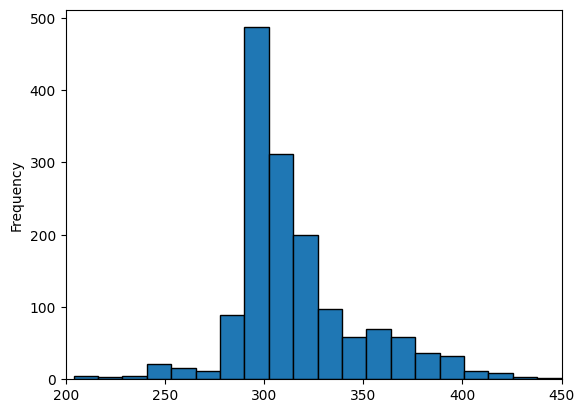

In [11]:
# Length of full length reference ZOTUs
display(md("## Sequence length of reference ZOTUs"))
display(df_refseq_full.describe())
df_refseq_full['refseq_length'].plot.hist(bins=20, xlim=(200, 450), edgecolor = "black")
plt.show()
